In [58]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [4]:
settings = yaml.safe_load('''
name: '032_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

In [5]:
fix_seed(settings['seed'])

In [6]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [7]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [8]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [9]:
df_test.head().T

,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [10]:
df_submission.head()

,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [11]:
train = df_train.copy()
test = df_test.copy()
train['is_test'] = False
test['is_test'] = True
whole = pd.concat([train, test])

## categry を見る

In [12]:
def countplot(df: pd.DataFrame, column: str) -> None:
    print(f'{column}: {df.loc[:, column].unique()}')
    plt.figure(figsize=(20, 8))
    sns.countplot(data=df, x=column, hue='is_test')
    plt.title(column)
    plt.tight_layout()

Platform: ['Wii' 'PSP' '2600' 'X360' 'PS3' 'GBA' 'DS' '3DS' 'PC' 'GC' 'GB' 'PS2'
 'N64' 'PSV' 'XB' 'NES' 'GEN' 'SNES' 'GG' 'NG' 'SCD' 'PS' 'SAT' '3DO'
 'TG16' 'PCFX' 'DC' 'WS' 'WiiU' 'PS4' 'XOne']


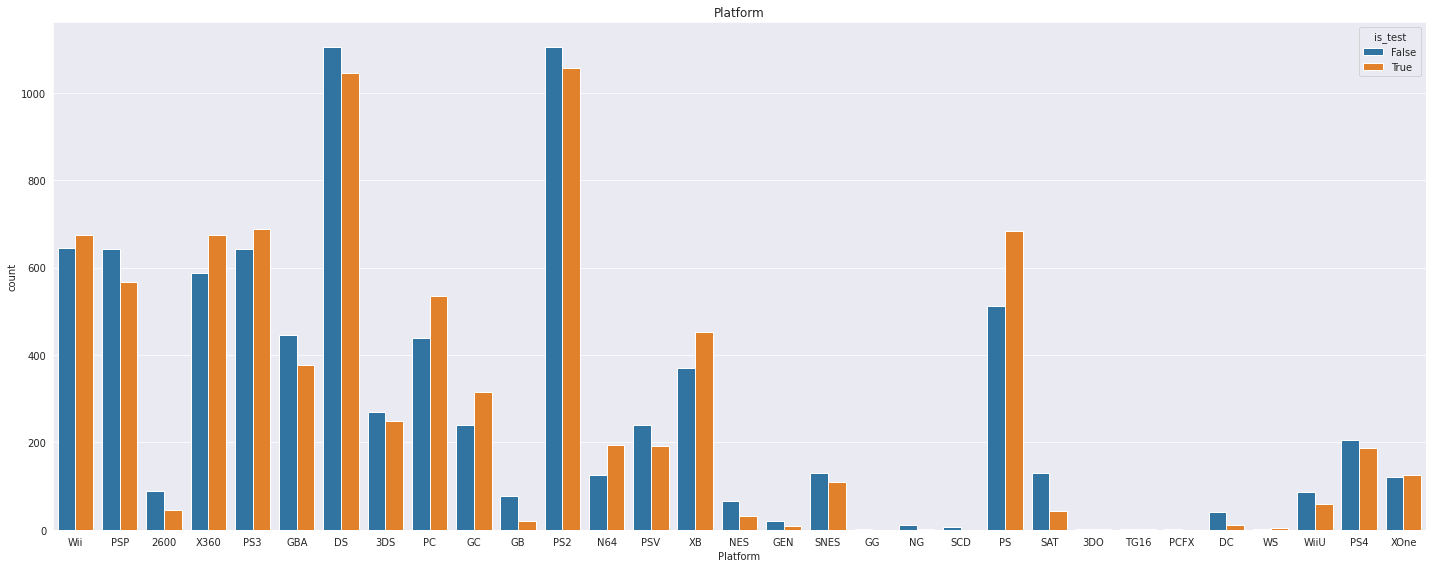

In [13]:
countplot(whole, 'Platform')

Year_of_Release: [  nan 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990.
 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002.
 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014.
 2015. 2016. 2017. 2020.]


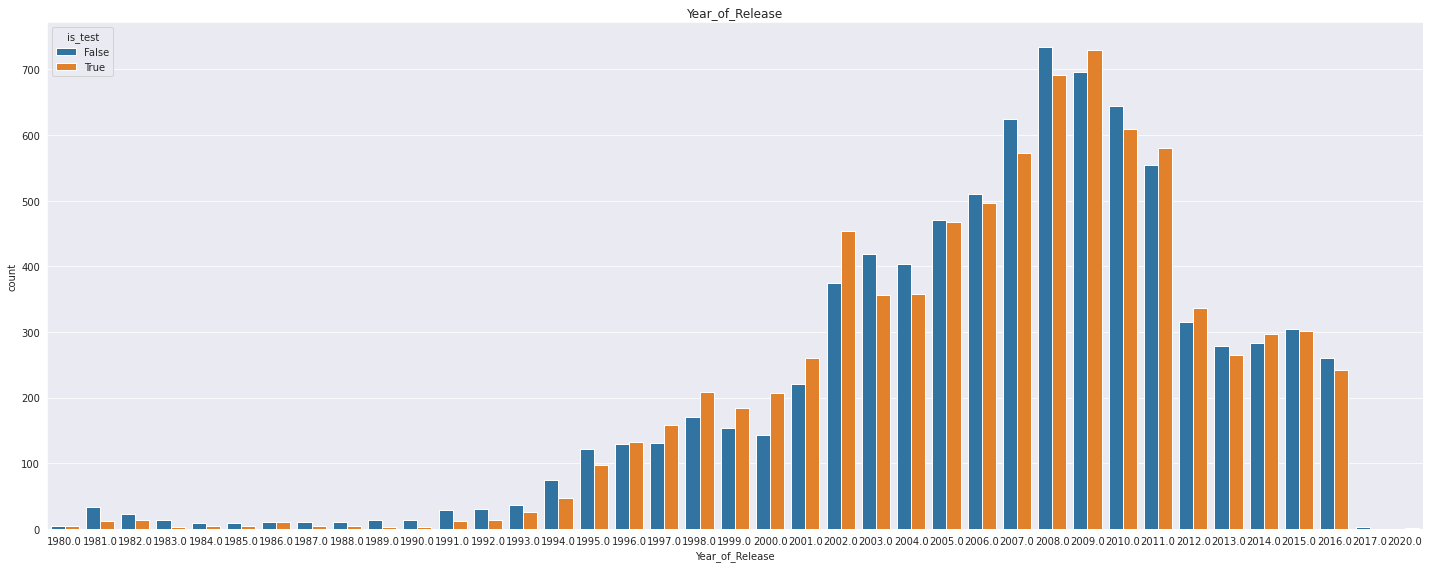

In [14]:
countplot(whole, 'Year_of_Release')

In [15]:
# Global_Sales で重み付け

<AxesSubplot:xlabel='Global_Sales', ylabel='Density'>

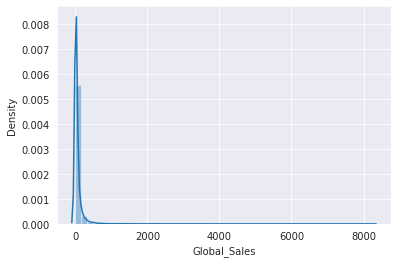

In [68]:
sns.distplot(train.loc[:, 'Global_Sales'])

69


<AxesSubplot:xlabel='Global_Sales', ylabel='Density'>

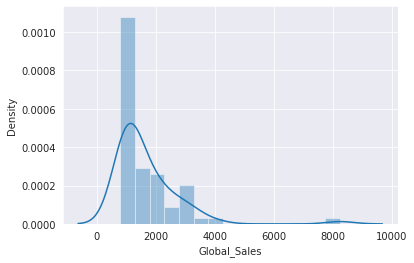

In [81]:
print(df_train[df_train.loc[:, 'Global_Sales'] > 800].shape[0])
sns.distplot(df_train.loc[df_train.loc[:, 'Global_Sales'] > 800, 'Global_Sales'])

In [34]:
# こんな感じで値段高いやつに weight 足すのはどうだろう

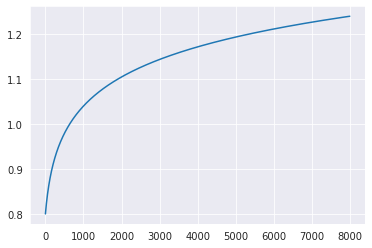

In [49]:
# 軽め
x = np.arange(0, 8000)
def weight(x):
    return np.log1p(x / 100.0) / 10.0 + 0.8
plt.plot(x, weight(x))

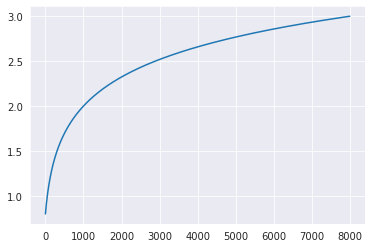

In [47]:
# 普通
x = np.arange(0, 8000)
def weight(x):
    return np.log1p(x / 100.0) / 2.0 + 0.8
plt.plot(x, weight(x))

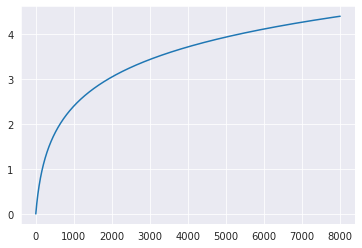

In [78]:
# 重め
x = np.arange(0, 8000)
def weight(x):
    return np.log1p(x / 100.0)
plt.plot(x, weight(x))

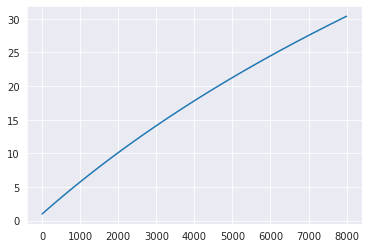

In [85]:
x = np.arange(0, 8000)
def weight(x):
    return np.log1p(x / 10000.0) / 0.02 + 1.0
plt.plot(x, weight(x))

In [66]:
mean_squared_log_error([400], [1000])

0.8368468768792238